In [ ]:
using OrdinaryDiffEq
using Plots
using QuantumAnnealingTools

# Redfield equation with multi-axis couplings
In this example, we solve Redfield equation with the folowing Hamiltonian
\begin{equation}
    H(s) = - \sigma_z + \sigma_x \otimes B_1 + \sigma_z \otimes B_2 + H_\mathrm{B}
\end{equation}
where $B_1$ and $B_2$ are independent Ohmic bath with different cutoff frequencies. First, we need to combine `AbstractCouplings` with `AbstractBath` into an `Interaction` object. Then we can combine different interactions into an `InteractionSet`.

In [63]:
coupling_1 = ConstantCouplings(["X"])
bath_1 = Ohmic(1e-4, 4, 16)
interaction_1 = Interaction(coupling_1, bath_1)

coupling_2 = ConstantCouplings(["Z"])
bath_2 = Ohmic(1e-4, 0.1, 16)
interaction_2 = Interaction(coupling_2, bath_2)

interaction_set = InteractionSet(interaction_1, interaction_2);

Finally, we can create `Annealing` object with `InteractionSet` instead of `coupling` and `bath`.

In [64]:
H = DenseHamiltonian([(s) -> 1.0], -[σz], unit = :ħ)
u0 = PauliVec[1][1]
annealing_1 = Annealing(H, u0, coupling=coupling_1, bath = bath_1)
annealing_2 = Annealing(H, u0, coupling=coupling_2, bath = bath_2)
annealing = Annealing(H, u0, interactions=interaction_set)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
custom system bath interactions

In [65]:
tf = 10
# Generate the unitary first
U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);

In the following block, we solve the Redfield equation with $X$, $Z$ and $X$ plus $Z$ couplings.

In [66]:
# Solve the Redfield equation
sol_1 = solve_redfield(annealing_1, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol_2 = solve_redfield(annealing_2, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol = solve_redfield(annealing, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6);

Then we plot $\langle X \rangle$ for all the different cases.

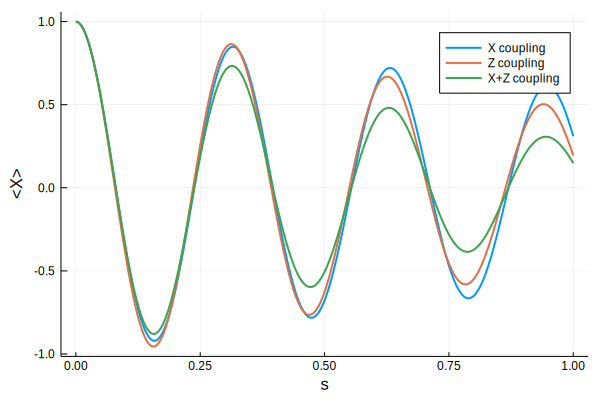

In [67]:
s_list = range(0,1,length=200)
x1 = []
x2 = []
x = []
for s in s_list
    push!(x1, real(tr(σx*sol_1(s))))
    push!(x2, real(tr(σx*sol_2(s))))
    push!(x, real(tr(σx*sol(s))))
end
x_nopulse = x1
plot(s_list, x1, linewidth=2, label="X coupling")
plot!(s_list, x2, linewidth=2, label="Z coupling")
plot!(s_list, x, linewidth=2, label="X+Z coupling")
xlabel!("s")
ylabel!("<X>")

Finally, we run the same simulation with a single $X$ pulse in the middle of the evolution (spin echo).

In [68]:
control = InstPulseControl([0.5], (x) -> σx)
annealing_1 = Annealing(H, u0, control = control, coupling = coupling_1, bath = bath_1)
annealing_2 = Annealing(H, u0, control = control, coupling=coupling_2, bath = bath_2)
annealing = Annealing(H, u0, control = control, interactions=interaction_set)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0 with size: (2,)
custom system bath interactions

In [69]:
tf = 10
U = solve_unitary(annealing, tf, alg=Tsit5(), abstol=1e-6, reltol=1e-6);

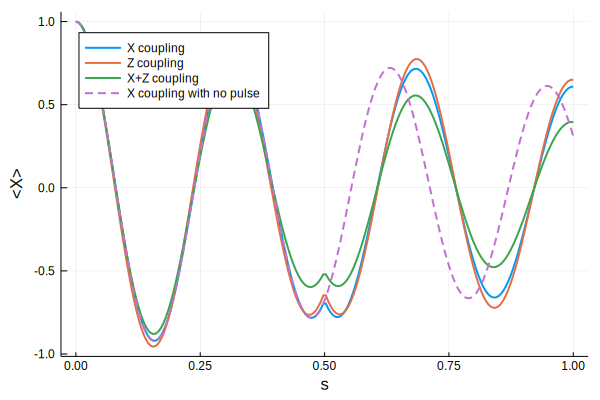

In [72]:
sol_1 = solve_redfield(annealing_1, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol_2 = solve_redfield(annealing_2, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6)
sol = solve_redfield(annealing, tf, U, alg = Tsit5(), abstol = 1e-6, reltol = 1e-6);
s_list = range(0,1,length=200)
x1 = []
x2 = []
x = []
for s in s_list
    push!(x1, real(tr(σx*sol_1(s))))
    push!(x2, real(tr(σx*sol_2(s))))
    push!(x, real(tr(σx*sol(s))))
end
plot(s_list, x1, linewidth=2, label="X coupling", legend=:topleft)
plot!(s_list, x2, linewidth=2, label="Z coupling")
plot!(s_list, x, linewidth=2, label="X+Z coupling")
plot!(s_list, x_nopulse, linewidth=2, linestyle=:dash, label="X coupling with no pulse")
xlabel!("s")
ylabel!("<X>")